# Разбиение данных о потреблении контента на оптимальное число кластеров

При необходимости разбить объекты на некоторое количество кластеров далеко не всегда бывает очевидным выбор их числа.

На сколько кластеров разбить? На 2? А не слишком ли это мало? На 15? А не слишком ли это  много? И далеко не всегда есть эксперт, который авторитетно заявит, что кластеров должно быть столько, сколько он сказал (хотя и в этом случае не стоит  пытаться заставить его объяснить, почему именно столько, скорее всего, он не объяснит).

В общем, в ситуации, когда нет объективных предпосылок, продиктованных спецификой данных (другими словами, когда аналитик предоставлен самому себе и просто работает со слепой таблицей чисел), а кластеризовать все-таки надо, тогда нужен метод, позволяющий подобрать оптимальное число кластеров.

Ниже реализован один из таких методов. Он не принадлежит лично мне. Идея сранивать качество кластеризации при помощи матриц соответствия принадлежит А. Буркову (США), но он не использовал ее для определения оптимального числа кластеров. 

Полный текст исследования читайте в [формате pdf](paper.pdf).

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap

import sklearn.linear_model as skl
import sklearn.model_selection as sklm
from sklearn.cluster import KMeans

## Чтение данных

In [15]:
df = pd.read_csv('data/data.csv')
df

,Просмотры,Время просмотра (часы),Поделились,Постоянные зрители,Новые комментарии,Отказались от подписки,Новые подписчики,Новые зрители,Среднее число просмотров одним пользователем,Уникальные зрители,CTR для значков видео (%),Показы,Подписчики,Средний процент просмотра (%),Процент лайков,Средняя продолжительность просмотра,Дизлайки,Лайки
0,475.0,21.2038,9.0,84.0,0.0,5.0,5.0,144.0,2.0833,228.0,4.25,5176.0,0.0,30.51,100.00,160.702484,0.0,16.0
1,174.0,5.4814,1.0,48.0,0.0,1.0,1.0,60.0,1.6111,108.0,4.05,2222.0,0.0,19.52,100.00,113.408276,0.0,4.0
2,490.0,17.8182,3.0,94.0,0.0,1.0,1.0,133.0,2.1586,227.0,5.27,5584.0,0.0,23.51,75.00,130.909224,1.0,3.0
3,665.0,25.9174,10.0,128.0,1.0,2.0,1.0,231.0,1.8524,359.0,5.78,6759.0,-1.0,25.35,100.00,140.304722,0.0,8.0
4,971.0,35.3850,4.0,166.0,0.0,3.0,7.0,362.0,1.8390,528.0,7.04,6736.0,4.0,21.72,85.71,131.190525,2.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,287.0,16.8233,0.0,55.0,0.0,0.0,4.0,97.0,1.8882,152.0,3.99,3156.0,4.0,41.29,90.91,211.023972,1.0,10.0
496,310.0,17.3132,0.0,47.0,0.0,4.0,4.0,89.0,2.2794,136.0,3.99,4359.0,0.0,40.61,85.71,201.056516,1.0,6.0
497,275.0,10.4130,1.0,44.0,0.0,1.0,4.0,63.0,2.5701,107.0,4.00,4176.0,3.0,26.91,100.00,136.315636,0.0,2.0
498,222.0,10.5967,0.0,46.0,1.0,2.0,3.0,69.0,1.9304,115.0,4.03,2976.0,1.0,33.30,66.67,171.838378,2.0,4.0


## Формирование сводной таблицы результатов

Мы прогоним действия по двумерной сетке: число кластеров будем изменять от 2 до 10, а процент тестовой выборки от 10 до 90 с шагом 10. Кроме того, поскольку каждый раз будет проводиться случайное разбиение на train и test, мы усредняем результаты при помощи множества запусков (в этом коде их 10, но для публикации исследования мы брали 100).

число кластеров 2
процент теста   10
доля совпадений 0.85824
число кластеров 2
процент теста   20
доля совпадений 0.86806
число кластеров 2
процент теста   30
доля совпадений 0.8414280075435288
число кластеров 2
процент теста   40
доля совпадений 0.936165
число кластеров 2
процент теста   50
доля совпадений 0.964
число кластеров 2
процент теста   60
доля совпадений 0.9474663635059216
число кластеров 2
процент теста   70
доля совпадений 0.8165761641545117
число кластеров 2
процент теста   80
доля совпадений 0.93626875
число кластеров 2
процент теста   90
доля совпадений 0.8630162962962963


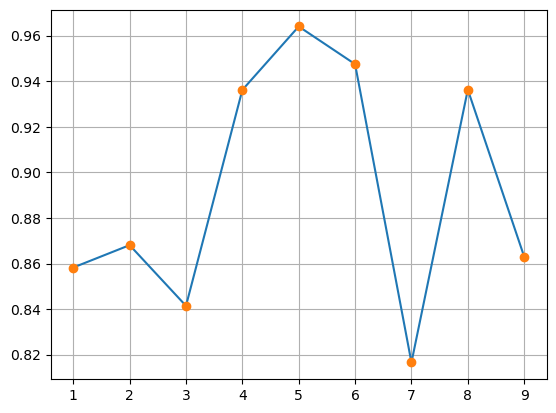


число кластеров 3
процент теста   10
доля совпадений 0.82936
число кластеров 3
процент теста   20
доля совпадений 0.73424
число кластеров 3
процент теста   30
доля совпадений 0.7769220648217183
число кластеров 3
процент теста   40
доля совпадений 0.7299100000000001
число кластеров 3
процент теста   50
доля совпадений 0.7309216000000001
число кластеров 3
процент теста   60
доля совпадений 0.7353472919724948
число кластеров 3
процент теста   70
доля совпадений 0.7400313309145218
число кластеров 3
процент теста   80
доля совпадений 0.77199125
число кластеров 3
процент теста   90
доля совпадений 0.7208720987654321


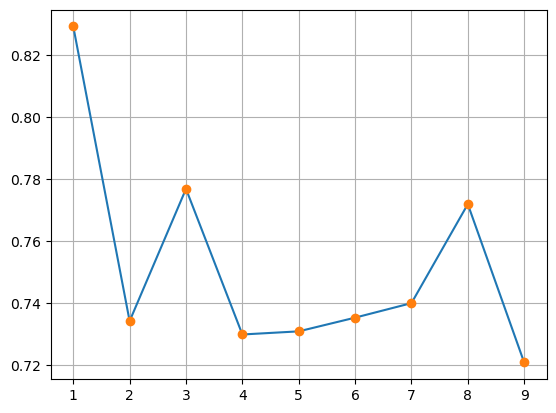


число кластеров 4
процент теста   10
доля совпадений 0.79496
число кластеров 4
процент теста   20
доля совпадений 0.7697
число кластеров 4
процент теста   30
доля совпадений 0.8479014078329898
число кластеров 4
процент теста   40
доля совпадений 0.8613
число кластеров 4
процент теста   50
доля совпадений 0.8504512
число кластеров 4
процент теста   60
доля совпадений 0.8690389730797674
число кластеров 4
процент теста   70
доля совпадений 0.8530709978003426
число кластеров 4
процент теста   80
доля совпадений 0.776105
число кластеров 4
процент теста   90
доля совпадений 0.8274587654320988


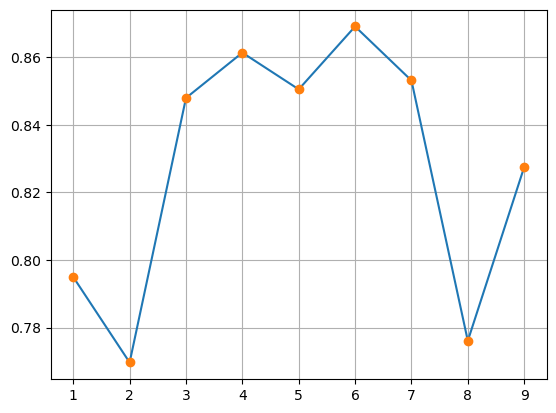


число кластеров 5
процент теста   10
доля совпадений 0.7595999999999999
число кластеров 5
процент теста   20
доля совпадений 0.8106599999999999
число кластеров 5
процент теста   30
доля совпадений 0.8128327704925222
число кластеров 5
процент теста   40
доля совпадений 0.818695
число кластеров 5
процент теста   50
доля совпадений 0.8168672
число кластеров 5
процент теста   60
доля совпадений 0.8144678314808887
число кластеров 5
процент теста   70
доля совпадений 0.7839725326904814
число кластеров 5
процент теста   80
доля совпадений 0.786585
число кластеров 5
процент теста   90
доля совпадений 0.7822508641975309


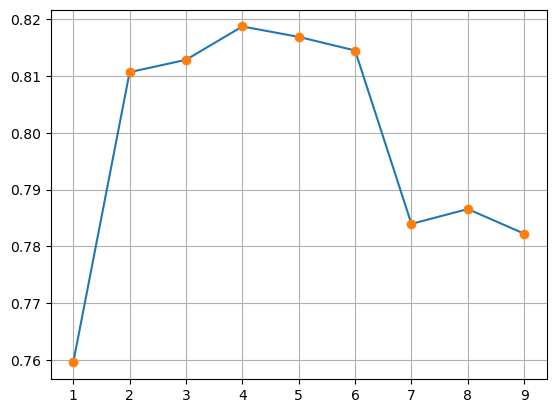


число кластеров 6
процент теста   10
доля совпадений 0.79136
число кластеров 6
процент теста   20
доля совпадений 0.81446
число кластеров 6
процент теста   30
доля совпадений 0.8015437919389501
число кластеров 6
процент теста   40
доля совпадений 0.795455
число кластеров 6
процент теста   50
доля совпадений 0.7902944
число кластеров 6
процент теста   60
доля совпадений 0.8081367755322789
число кластеров 6
процент теста   70
доля совпадений 0.8007110331896656
число кластеров 6
процент теста   80
доля совпадений 0.7559475
число кластеров 6
процент теста   90
доля совпадений 0.7684335802469136


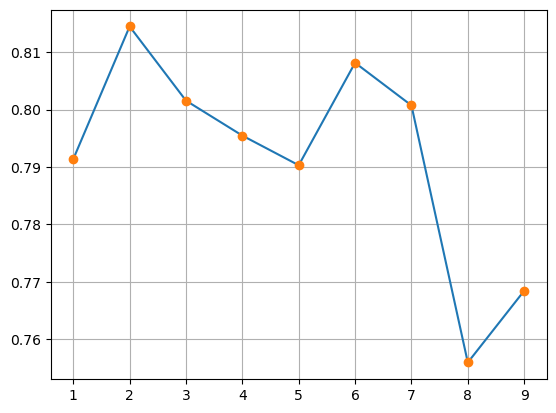


число кластеров 7
процент теста   10
доля совпадений 0.8308800000000001
число кластеров 7
процент теста   20
доля совпадений 0.79774
число кластеров 7
процент теста   30
доля совпадений 0.8164027893513442
число кластеров 7
процент теста   40
доля совпадений 0.7980349999999999
число кластеров 7
процент теста   50
доля совпадений 0.8105152
число кластеров 7
процент теста   60
доля совпадений 0.7994966942969725
число кластеров 7
процент теста   70
доля совпадений 0.8055908637105218
число кластеров 7
процент теста   80
доля совпадений 0.80842375
число кластеров 7
процент теста   90
доля совпадений 0.7986261728395061


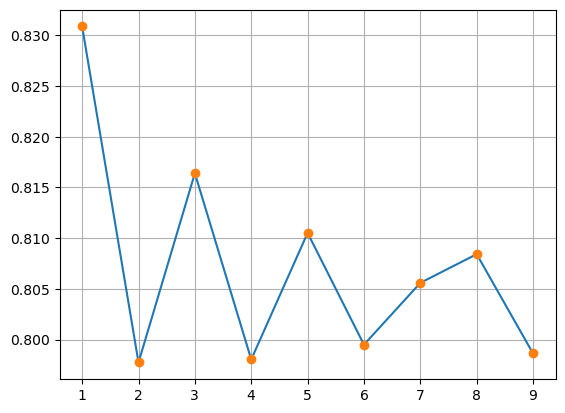


число кластеров 8
процент теста   10
доля совпадений 0.8264
число кластеров 8
процент теста   20
доля совпадений 0.82332
число кластеров 8
процент теста   30
доля совпадений 0.8218499188632078
число кластеров 8
процент теста   40
доля совпадений 0.82075
число кластеров 8
процент теста   50
доля совпадений 0.8331584000000001
число кластеров 8
процент теста   60
доля совпадений 0.834010662133972
число кластеров 8
процент теста   70
доля совпадений 0.8250679783443317
число кластеров 8
процент теста   80
доля совпадений 0.8081425
число кластеров 8
процент теста   90
доля совпадений 0.7888879012345679


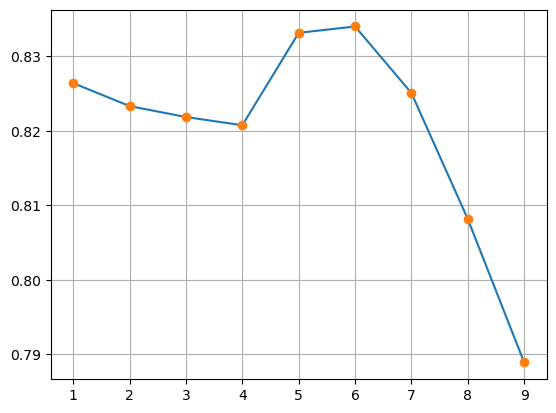


число кластеров 9
процент теста   10
доля совпадений 0.84056
число кластеров 9
процент теста   20
доля совпадений 0.84488
число кластеров 9
процент теста   30
доля совпадений 0.8352616113328363
число кластеров 9
процент теста   40
доля совпадений 0.83621
число кластеров 9
процент теста   50
доля совпадений 0.8427648
число кластеров 9
процент теста   60
доля совпадений 0.8280394256134038
число кластеров 9
процент теста   70
доля совпадений 0.8169349274762381
число кластеров 9
процент теста   80
доля совпадений 0.8283612499999999
число кластеров 9
процент теста   90
доля совпадений 0.8065718518518519


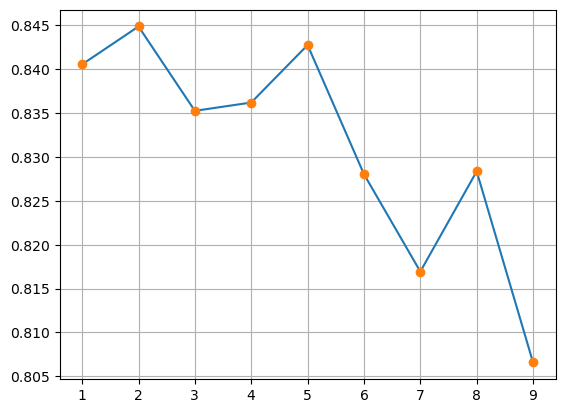


число кластеров 10
процент теста   10
доля совпадений 0.84832
число кластеров 10
процент теста   20
доля совпадений 0.84894
число кластеров 10
процент теста   30
доля совпадений 0.8413402920924521
число кластеров 10
процент теста   40
доля совпадений 0.85512
число кластеров 10
процент теста   50
доля совпадений 0.8449088
число кластеров 10
процент теста   60
доля совпадений 0.8467699032019513
число кластеров 10
процент теста   70
доля совпадений 0.8380841064601748
число кластеров 10
процент теста   80
доля совпадений 0.8465962499999999
число кластеров 10
процент теста   90
доля совпадений 0.8277501234567901


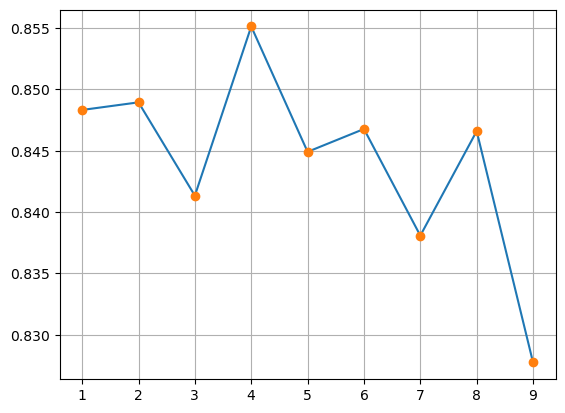

In [3]:
#  Заводим датафрейм для сводной таблицы результатов
df_results = pd.DataFrame(columns = np.arange(1, 10)*10)

# Внешний цикл по числу кластеров
for c in range(2, 11):
    
    # Сюда будем аппендить доли совпадений
    P = []
    
    # Вложенный цикл по проценту теста
    for d in range(1, 10):
        
        # Сюда будем аппендить долю совпадений в матрицах соответствия
        procent_list = []

        # Множественные запуски на случайных разбиениях для последующего усреднения
        for a in range(10):
            
            # Нормируем данные, а то у них слишком большой разброс занчений (разница на порядки)
            df = (df - df.mean())/df.std()
            
            # Разбиваем на train и test (random_state отключен, разбиения всегда разные)
            df_train, df_test = sklm.train_test_split(df, test_size = 0.1 * d)
            
            # Переводим датафреймы в массивы
            X_train = df_train.to_numpy()
            X_test = df_test.to_numpy()

            # Завоим модель кластеризации
            clust_train = KMeans(n_clusters = c)
            # Фитим ее на трейне
            clust_train.fit(X_train)
            # Выводим метки объектов в отдельный массив
            labels_train_test = clust_train.predict(X_test)
            
            # Дальше формируем матрицу соответствий
            # Сначала Заводим матрицу размером с тестовую выборку. Целиком из нулей
            M_train_test = np.zeros((len(df_test), len(df_test)))
            
            # Потом некоторые ее места заполняем единицами, если выполнено условие
            for i in range(len(df_test)):
                for j in range(len(df_test)):
                    if labels_train_test[i] == labels_train_test[j]:
                        M_train_test[i][j] = 1


            # Потом точно так же для тестовой выборки. 
            # Разница здесь только в том, что учим модель теперь на тестовой выборке
            # В итоге получается еще одна матрица с нулями и единицами
            clust_test = KMeans(n_clusters = c)
            clust_test.fit(X_test)

            labels_test = clust_test.labels_

            M_test = np.zeros((len(df_test), len(df_test)))

            for i in range(len(df_test)):
                for j in range(len(df_test)):
                    if labels_test[i] == labels_test[j]:
                        M_test[i][j] = 1


            # Так получается доля НЕ совпадений
            procent_list.append(abs((M_train_test - M_test)).sum()/(len(df_test)**2))

        procent = np.array(procent_list).mean()
        
        print('число кластеров', c)
        print('процент теста  ', d*10)
        
        # А так -- доля совпадений
        print('доля совпадений', 1 - procent)
        
        # И именно ее мы аппендим в P. Чем выше доля совпадений, тем лучше
        P.append(1 - procent)

    df_results.loc[len(df_results)] = np.array(P)


    plt.grid()
    plt.plot(np.arange(1, 10), np.array(P), '-')
    plt.plot(np.arange(1, 10), np.array(P), 'o')
    plt.show()
    print('')

In [4]:
# Посмотрели на сводную таблицу
df_results

,10,20,30,40,50,60,70,80,90
0,0.85824,0.86806,0.841428,0.936165,0.964000,0.947466,0.816576,0.936269,0.863016
1,0.82936,0.73424,0.776922,0.729910,0.730922,0.735347,0.740031,0.771991,0.720872
2,0.79496,0.76970,0.847901,0.861300,0.850451,0.869039,0.853071,0.776105,0.827459
3,0.75960,0.81066,0.812833,0.818695,0.816867,0.814468,0.783973,0.786585,0.782251
4,0.79136,0.81446,0.801544,0.795455,0.790294,0.808137,0.800711,0.755947,0.768434
5,0.83088,0.79774,0.816403,0.798035,0.810515,0.799497,0.805591,0.808424,0.798626
6,0.82640,0.82332,0.821850,0.820750,0.833158,0.834011,0.825068,0.808142,0.788888
7,0.84056,0.84488,0.835262,0.836210,0.842765,0.828039,0.816935,0.828361,0.806572
8,0.84832,0.84894,0.841340,0.855120,0.844909,0.846770,0.838084,0.846596,0.827750


In [5]:
# Вывели ее на всякий случай в буферный файл, чтобы не глать весь цикл заново в случае чего

# df_results.to_csv('data/results.csv', index = False)

In [17]:
# Прочитали из буфера
d = pd.read_csv('data/results.csv')
d

,10,20,30,40,50,60,70,80,90
0,0.85824,0.86806,0.841428,0.936165,0.964000,0.947466,0.816576,0.936269,0.863016
1,0.82936,0.73424,0.776922,0.729910,0.730922,0.735347,0.740031,0.771991,0.720872
2,0.79496,0.76970,0.847901,0.861300,0.850451,0.869039,0.853071,0.776105,0.827459
3,0.75960,0.81066,0.812833,0.818695,0.816867,0.814468,0.783973,0.786585,0.782251
4,0.79136,0.81446,0.801544,0.795455,0.790294,0.808137,0.800711,0.755947,0.768434
5,0.83088,0.79774,0.816403,0.798035,0.810515,0.799497,0.805591,0.808424,0.798626
6,0.82640,0.82332,0.821850,0.820750,0.833158,0.834011,0.825068,0.808142,0.788888
7,0.84056,0.84488,0.835262,0.836210,0.842765,0.828039,0.816935,0.828361,0.806572
8,0.84832,0.84894,0.841340,0.855120,0.844909,0.846770,0.838084,0.846596,0.827750


## Иллюстрации

Здесь есть небольшое несовпадение с тем, что в [публикации pdf](paper.pdf). Но это потому что выполнялись случайные разбиения, объем генеральной совокпности всего 500, и запусков для усреднения мы сделали всего 10. Когда готовилась публикация было 100 запусков.

Об этом есть несколько слов в публикации.

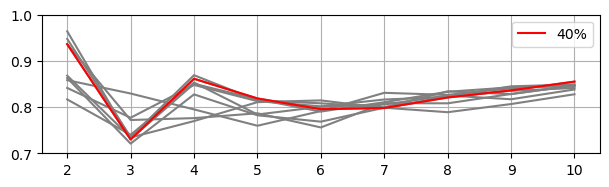

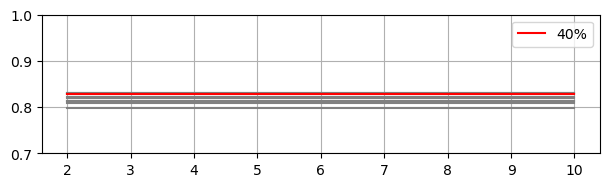

In [7]:
cols = d.columns

plt.figure(figsize = (7.2, 1.8))

plt.grid()
plt.ylim((0.7, 1))
for i in range(len(cols)):
    plt.plot(np.arange(2, 11), d[cols[i]].to_numpy(), '-', color = 'grey')
    
plt.plot(np.arange(2, 11), d[cols[3]].to_numpy(), '-', color = 'red', label='40%')
plt.legend()

plt.savefig('Кластеры-доля.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

cols = d.columns

plt.figure(figsize = (7.2, 1.8))

plt.grid()
plt.ylim((0.7, 1))
for i in range(len(cols)):
    plt.plot(np.arange(2, 11), [d[cols[i]].to_numpy().mean()]*len(cols), '-', color = 'grey')
    
plt.plot(np.arange(2, 11), [d[cols[3]].to_numpy().mean()]*len(cols), '-', color = 'red', label='40%')
plt.legend()
plt.savefig('Кластеры-доля. Средние.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

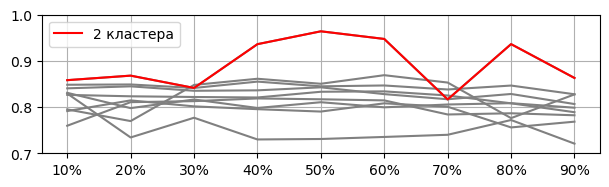

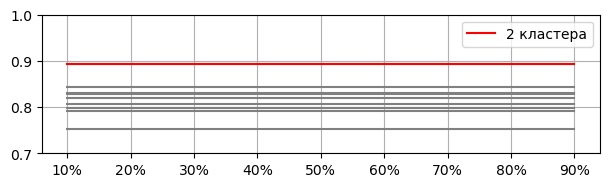

In [8]:
plt.figure(figsize = (7.2, 1.8))

plt.grid()
plt.xticks(np.arange(1, 10), ['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%'])
plt.ylim((0.7, 1))
for i in range(len(d)):
    plt.plot(np.arange(1, 10), d.iloc[i].to_numpy(), '-', color = 'grey')
    
plt.plot(np.arange(1, 10), d.iloc[0].to_numpy(), '-', color = 'red', label='2 кластера')
plt.legend()
#plt.savefig('Проценты-доля.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()


plt.figure(figsize = (7.2, 1.8))

plt.grid()
plt.xticks(np.arange(1, 10), ['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%'])
plt.ylim((0.7, 1))
for i in range(len(d)):
    plt.plot(np.arange(1, 10), [d.iloc[i].to_numpy().mean()]*len(np.arange(1, 10)), '-', color = 'grey')
    
plt.plot(np.arange(1, 10), [d.iloc[0].to_numpy().mean()]*len(np.arange(1, 10)), '-', color = 'red', label='2 кластера')
plt.legend()
#plt.savefig('Проценты-доля.Средние.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()